# Indus Valley Scripts - ICIT coded Text Analysis for Decipherment

# Textual Analysis

Dataset was created as a csv file from ICIT web site from raw html files for each for the Text
Data labels were changes and a linearized copy of the original text was added

icit_text_text_corpus.csv


!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install nltk
!pip install ipywidgets
!pip install -U dill
!pip3 install requests
!pip3 install -U spacy

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import collections
import traceback

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from collections import defaultdict

In [3]:
CONST_NL=10 #Normalized length

In [4]:
# Set the filters on data here
drop_duplicate_texts = True

filter_by_site = False
filter_by_keywords = False

#site = 'Mohenjo-daro'
site = 'Harappa'
keyword = "Bull1"

num_rows= 4999

In [5]:
orig_df=pd.read_csv('../../IndusCorpusUtils/data/icit_corpus/icit_text_text_corpus.csv',dtype=str, nrows=num_rows)
# set the max columns to none
pd.set_option('display.max_columns', None)

orig_df

,icit_id,site,keywords,text_class,lines,direction,text,signs,complete,alignment,sign height,text_images,linearized_text,standardized_text
0,1,Alamgirpur,NaN,SS,1,L/R,+410-017+,2,Y,Unordered,Unequal,NaN,410 017,410 017
1,2,Alamgirpur,NaN,SS,1,L/R,+410-017+,2,Y,NaN,NaN,NaN,410 017,410 017
2,3,Alamgirpur,NaN,SC,1,L/R,+405-017+,2,Y,NaN,NaN,NaN,405 017,405 017
3,4,Allahdino,NaN,??,1,NaN,+220-000+,1,N,NaN,NaN,NaN,220 000,000 220
4,5,Allahdino,Bull,UC,1,R/L,+740-235+,2,Y,NaN,NaN,NaN,740 235,235 740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4064,Harappa,NaN,UC,1,NaN,+000[,0,N,Indefinable,Indefinable,NaN,000[,000[
4995,4065,Harappa,NaN,VN,1,R/L,]700-032[,2,?,NaN,NaN,NaN,700 032[,032[ 700
4996,4065,Harappa,NaN,UC,1,R/L,]000-000[,0,N,NaN,NaN,NaN,000 000[,000[ 000
4997,4066,Harappa,NaN,UC,1,R/L,+368-000+,1,N,NaN,NaN,NaN,368 000,000 368


In [6]:
#Reverse text and add that as a new column
# Add text length as a column
list_reversed_text = []
for text in orig_df[orig_df.standardized_text!=''].standardized_text:
    # Tokenize to words
    # first split the string into chars
    chars = text.split(' ')
    length = len(chars)

    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    list_reversed_text.append(reversed_text)
    
orig_df['reversed_text']= list_reversed_text
orig_df['text_length']= length

print("Dataframe has ", len(orig_df.index), " rows")

Dataframe has  4999  rows


In [7]:
# Retain texts that are only wanted

#remove the values where the text is unclear
df = orig_df[orig_df['standardized_text'].str.contains('000') == False] 

print("After removing unclear texts, we have ", len(df.index), " rows")

if(drop_duplicate_texts):
    #Remove out duplicate inplace
    df.drop_duplicates(subset ="text",
                         keep = False, inplace = True)

    print("After removing duplicate texts, we have ", len(df.index), " rows")


#keep only the values that does not have multi-line text
df = df[df['text'].str.contains('/') == False] 

print("After removing multi-line text, we have ", len(df.index), " rows")


#keep only the values where the direction is known (if direction does not have a /, i,e. L/R or R/L)
#Btw standardized_text is Left to right as in English
df = df[df['direction'].str.contains('/') == True] 

print("After keeping only text with known direction, we have ", len(df.index), " rows")

#Remove Multipart texts that have [ or ]
df = df[df['standardized_text'].str.contains("\[") == False] 
df = df[df['standardized_text'].str.contains("\]") == False] 

print("After keeping only text without multipart, we have ", len(df.index), " rows")


After removing unclear texts, we have  3945  rows
After removing duplicate texts, we have  2130  rows
After removing multi-line text, we have  2053  rows
After keeping only text with known direction, we have  1813  rows
After keeping only text without multipart, we have  1659  rows


/var/folders/0n/5lj8g_xs6xngc99x77p4k50h0000gp/T/ipykernel_55973/2705541693.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset ="text",


In [8]:
if(filter_by_site==True):
    #keep only the values that matches the provided site
    df = df[df['site'].str.contains(site) == True] 
    print("After filtering by site ", site, " it has ", len(df.index), " rows")

if(filter_by_keywords==True):
     #keep only the values that matches the provided keyword
    df = df[df['keywords'].str.contains(keyword) == True] 
    print("After filtering by keywords ", keyword, " it has ", len(df.index), " rows")

In [9]:
#Keep the items with unclear text in another dataframe
df_unclear = orig_df[orig_df['standardized_text'].str.contains('000') == True]

#Note: Lot of the text with unclear text have direction empty

### Feature Extraction

In [10]:
y=df['site'].values
y.shape

# y axis is still the same
y_rev=df['site'].values
y_rev.shape

(1659,)

In [11]:
x=df['standardized_text'].values
x.shape

x_rev=df['reversed_text'].values
x_rev.shape

(1659,)

### Train-test split for doing cluster, model anlysis for later

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
(x_train,x_test,y_train,y_test)=train_test_split(x,y,test_size=0.1, random_state=43)

(x_rev_train,x_rev_test,y_rev_train,y_rev_test)=train_test_split(x_rev,y_rev,test_size=0.1, random_state=43)

In [14]:
#Train data, fwd and reverse
df_train_x=pd.DataFrame(x_train)
df_train_x=df_train_x.rename(columns={0:'standardized_text'})

df_train_y=pd.DataFrame(y_train)
df_train_y=df_train_y.rename(columns={0:'site'})

df_train_x_rev=pd.DataFrame(x_rev_train)
df_train_x_rev=df_train_x_rev.rename(columns={0:'reversed_text'})

df_train_y_rev=pd.DataFrame(y_rev_train)
df_train_y_rev=df_train_y_rev.rename(columns={0:'site'})

#Test data, fwd and reverse
df_test_x=pd.DataFrame(x_test)
df_test_x=df_test_x.rename(columns={0:'standardized_text'})

df_test_y=pd.DataFrame(y_test)
df_test_y=df_test_y.rename(columns={0:'site'})

df_test_x_rev=pd.DataFrame(x_rev_test)
df_test_x_rev=df_test_x_rev.rename(columns={0:'reversed_text'})

df_test_y_rev=pd.DataFrame(y_rev_test)
df_test_y_rev=df_test_y_rev.rename(columns={0:'site'})

In [15]:
df_train=pd.concat([df_train_x,df_train_y],axis=1)
#print(df_train.head())

df_test=pd.concat([df_test_x,df_test_y],axis=1)
#print(df_test.head())


df_train_rev=pd.concat([df_train_x_rev,df_train_y_rev],axis=1)
#print(df_train_rev.head())

df_test_rev=pd.concat([df_test_x_rev,df_test_y_rev],axis=1)
#print(df_test_rev.head())

## First let us do stats on the whole data. Ignore df_train and df_test for now

## Text Length Analysis

In [46]:
text_lengths=defaultdict(int)
total_length=0
total_count=0
for text in df[df.standardized_text!=''].standardized_text:
    chars = text.split(' ')
    length = len(chars)
    text_lengths[length]+=1
    total_length = total_length +length
    total_count = total_count+1

print('Average Text Length:',round(total_length/total_count,2) )
#print(text_lengths.items())

df_text_lengths=pd.DataFrame(sorted(text_lengths.items(),key=lambda x:x[1],reverse=True))
pd_text_lengths1=df_text_lengths[0][:20]
pd_text_lengths2=df_text_lengths[1][:20]

Average Text Length: 4.66


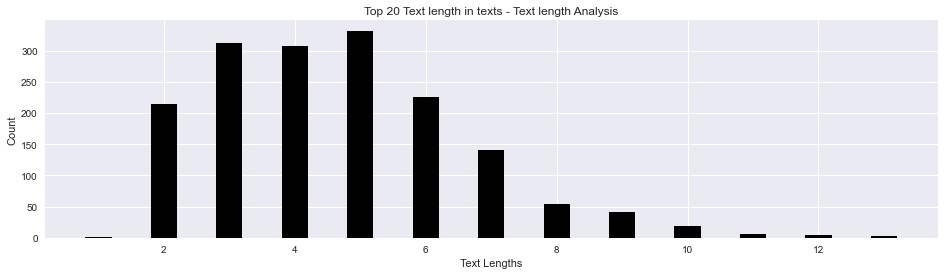

In [17]:
plt.figure(1,figsize=(16,4))

plt.bar(pd_text_lengths1,pd_text_lengths2, color ='black',
        width = 0.4)
 
plt.xlabel("Text Lengths")
plt.ylabel("Count")
plt.title("Top 20 Text length in texts - Text length Analysis")

plt.savefig("text-length.png")
plt.show()

## N Gram Analysis of the Texts

In [18]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [19]:
# Get ngram as list given a text
def get_ngrams_as_list(data, num):
    n_grams =  ngrams(nltk.word_tokenize(data), num)
    return  [ ' '.join(grams) for grams in n_grams]

In [20]:
text_unigrams=defaultdict(int)
text_bigrams=defaultdict(int)
text_trigrams=defaultdict(int)
text_quadgrams=defaultdict(int)

In [21]:
#Tokenize the text

tokenized_text = list(df[df.standardized_text!=''].standardized_text.apply(word_tokenize))
reverse_tokenized_text = list(df[df.reversed_text!=''].reversed_text.apply(word_tokenize))

#print("tokenized_text:",tokenized_text)

In [22]:
for text in df[df.standardized_text!=''].standardized_text:
  for word in get_ngrams_as_list(text,1):
    text_unigrams[word]+=1

#text_unigrams.items()

In [23]:
for text in df[df.standardized_text!=''].standardized_text:
  for word in get_ngrams_as_list(text,2):
    text_bigrams[word]+=1

#text_bigrams.items()

In [24]:
for text in df[df.standardized_text!=''].standardized_text:
  for word in get_ngrams_as_list(text,3):
    text_trigrams[word]+=1

#text_trigrams.items()

In [25]:
for text in df[df.standardized_text!=''].standardized_text:
  for word in get_ngrams_as_list(text,4):
    text_quadgrams[word]+=1

#text_quadgrams.items()

In [26]:
df_text_unigrams=pd.DataFrame(sorted(text_unigrams.items(),key=lambda x:x[1],reverse=True))
df_text_bigrams=pd.DataFrame(sorted(text_bigrams.items(),key=lambda x:x[1],reverse=True))
df_text_trigrams=pd.DataFrame(sorted(text_trigrams.items(),key=lambda x:x[1],reverse=True))
df_text_quadgrams=pd.DataFrame(sorted(text_quadgrams.items(),key=lambda x:x[1],reverse=True))

In [27]:
print("Number of distinct Unigrams", len(df_text_unigrams))
print("Number of distinct Bigrams", len(df_text_bigrams))
print("Number of distinct Trigrams", len(df_text_trigrams))
print("Number of distinct Quadgrams", len(df_text_quadgrams))

Number of distinct Unigrams 563
Number of distinct Bigrams 2733
Number of distinct Trigrams 3384
Number of distinct Quadgrams 2747


In [28]:
pd_text_unigrams1=df_text_unigrams[0][:20]
pd_text_unigrams2=df_text_unigrams[1][:20]

pd_text_bigrams1=df_text_bigrams[0][:20]
pd_text_bigrams2=df_text_bigrams[1][:20]

pd_text_trigrams1=df_text_trigrams[0][:10]
pd_text_trigrams2=df_text_trigrams[1][:10]

pd_text_quadgrams1=df_text_quadgrams[0][:10]
pd_text_quadgrams2=df_text_quadgrams[1][:10]

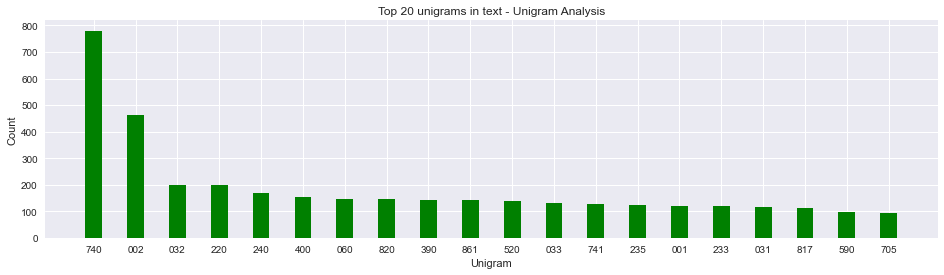

In [29]:
plt.figure(2,figsize=(16,4))

plt.bar(pd_text_unigrams1,pd_text_unigrams2, color ='green',
        width = 0.4)
 
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Top 20 unigrams in text - Unigram Analysis")

plt.savefig("text-unigram.png")
plt.show()

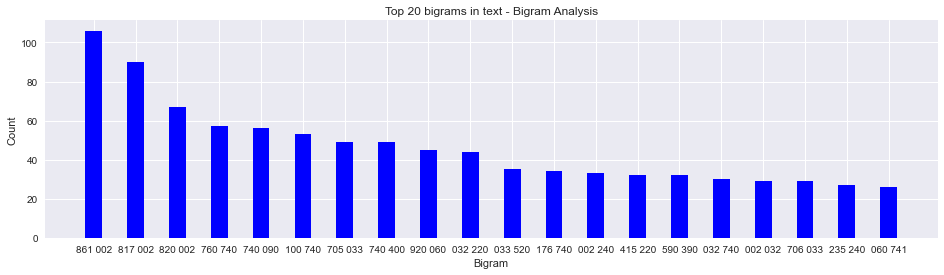

In [30]:
plt.figure(3,figsize=(16,4))

plt.bar(pd_text_bigrams1,pd_text_bigrams2, color ='blue',
        width = 0.4)
 
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 20 bigrams in text - Bigram Analysis")

plt.savefig("text-bigram.png")
plt.show()

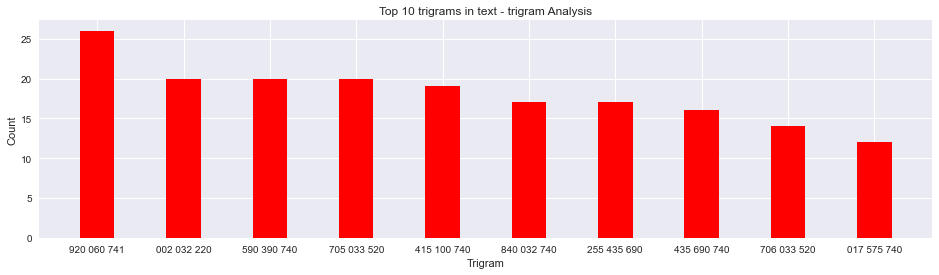

In [31]:
plt.figure(4,figsize=(16,4))

plt.bar(pd_text_trigrams1,pd_text_trigrams2, color ='red',
        width = 0.4)
 
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 10 trigrams in text - trigram Analysis")

plt.savefig("text-trigram.png")
plt.show()

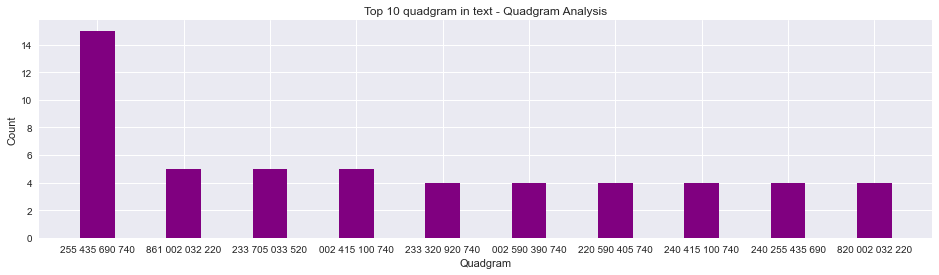

In [32]:
plt.figure(5,figsize=(16,4))

plt.bar(pd_text_quadgrams1,pd_text_quadgrams2, color ='purple',
        width = 0.4)
 
plt.xlabel("Quadgram")
plt.ylabel("Count")
plt.title("Top 10 quadgram in text - Quadgram Analysis")

plt.savefig("text-quadgram.png")
plt.show()

## More Statistical Analysis

# Text Positional Analysis

In [33]:
# To get a Positional Number for a unigram, bigram, trigram and Quadgram
# l = Length of the text
# s = starting position of the first character of the ngram
# wp = weighted position = int(s/l)

In [34]:
# Get the normalized position
# Since the text passed is L/R,start index i from length of the text
def get_norm_position(text, match_char):
    
    l, minp, maxp,w = 0,0,0,0
    #print("text:", text,"character", match_char)
    
    chars = text.split(' ')
    l = len(chars)
    i=l   
    for char in chars:
        if(char==match_char):
            sp = i
            break
        i=i-1
        
    minp= int((sp-1)* (CONST_NL/l) +1)
    maxp = int(sp*CONST_NL/l)
    w= l/CONST_NL
    return minp, maxp, w
    

In [35]:
from typing import Dict
text_norm_position_unigrams=defaultdict(dict[int, int])

In [36]:
i=0
try:
    #Fill the values with zeros in decreasing order so that we can keep same order in graph
    for text in df[df.standardized_text!=''].standardized_text:
      for word in get_ngrams_as_list(text,1):
        for j in range (10,-1, -1):
            text_norm_position_unigrams[word][j]=0
        
    for text in df[df.standardized_text!=''].standardized_text:
      for word in get_ngrams_as_list(text,1):
        beginning_char = word # for unigram
        minp, maxp, w = get_norm_position(text, beginning_char)
        norm_pos =round((minp + maxp)/2)

        if(norm_pos> CONST_NL): norm_pos = CONST_NL
        elif(norm_pos<0): norm_pos = 0

        #print(i,":Text:",text, "Char:", beginning_char, minp, maxp, w," Norm Pos:",norm_pos)
        val = text_norm_position_unigrams[word].get(norm_pos,0)
        text_norm_position_unigrams[word][norm_pos]= val+1

        i=i+1

    #print(text_norm_position_unigrams.items())
except Exception as e:
        print("Exception:", e.__class__, "Building the positional unigram")
        traceback.print_exc()

In [37]:
df_text_norm_position_unigrams=pd.DataFrame(text_norm_position_unigrams)
#print(df_text_norm_position_unigrams)

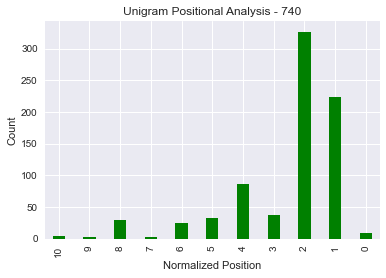

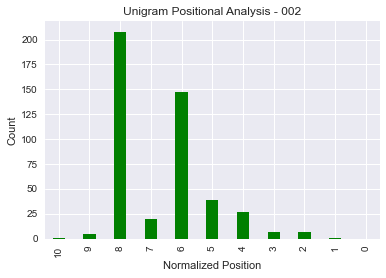

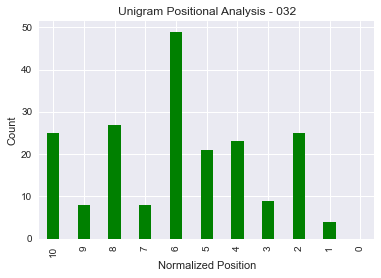

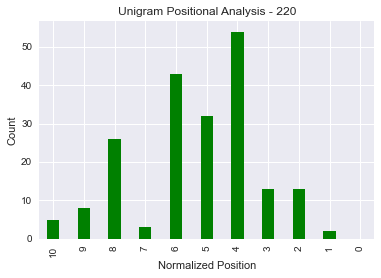

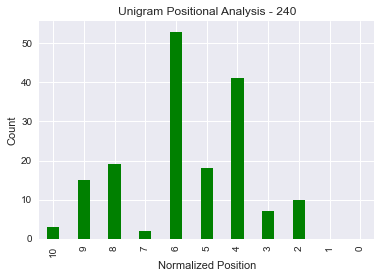

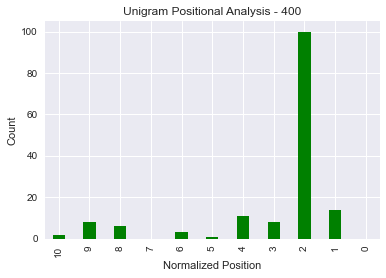

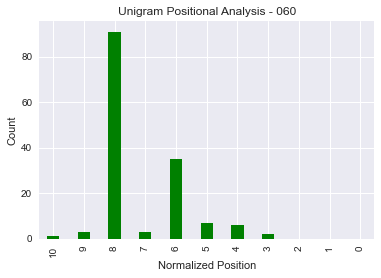

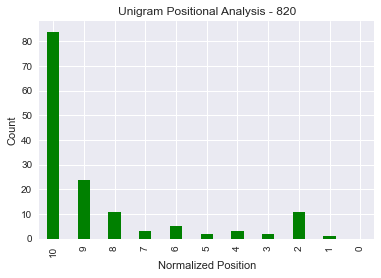

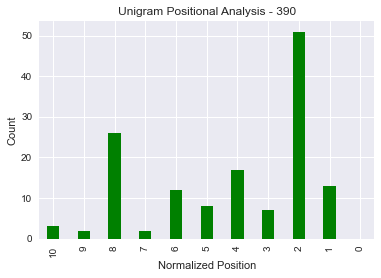

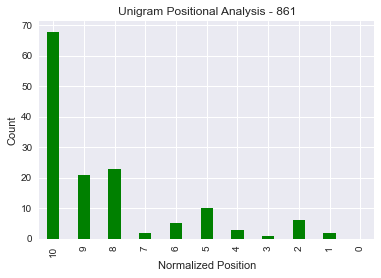

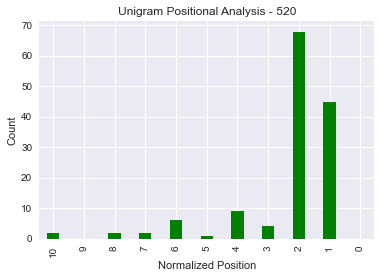

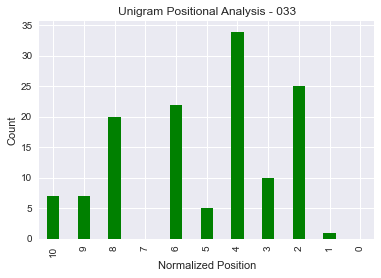

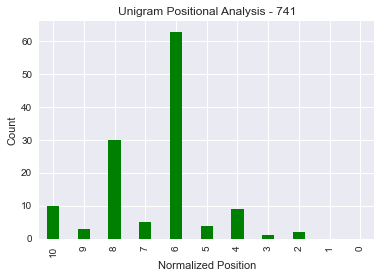

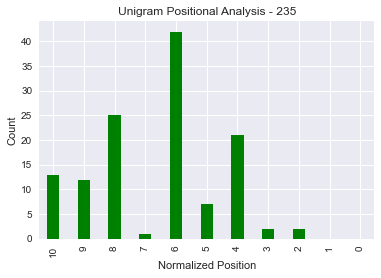

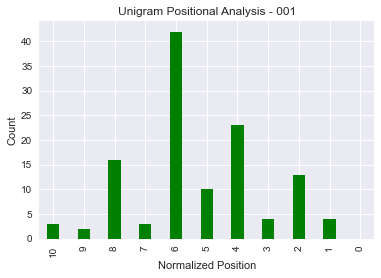

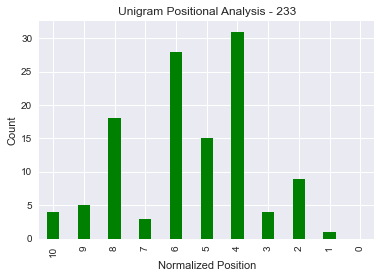

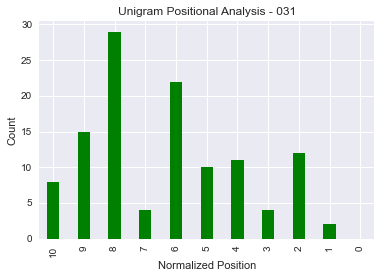

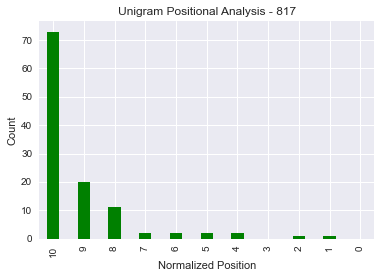

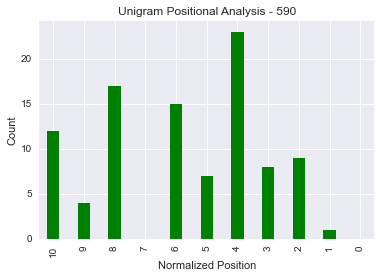

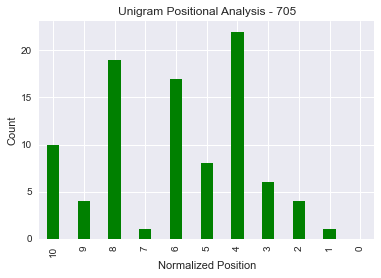

In [38]:
for unigram in pd_text_unigrams1:
    df_text_norm_position_unigrams[unigram].plot(kind='bar', width = 0.4, color='green')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Count")
    plt.title("Unigram Positional Analysis - " + unigram)
    plt.show()


In [39]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()
for text in df[df.standardized_text!=''].standardized_text.apply(word_tokenize):
    #print(text)
    finder = BigramCollocationFinder.from_documents(text)
    print(finder.nbest(bigram_measures.pmi, 10))

[('2', '3'), ('3', '5'), ('4', '0'), ('7', '4')]
[('1', '2'), ('2', '5'), ('6', '8'), ('9', '0'), ('3', '6'), ('3', '9'), ('0', '3'), ('3', '3')]
[('2', '3'), ('7', '4'), ('9', '0'), ('3', '5'), ('0', '4'), ('0', '5'), ('4', '0'), ('7', '0'), ('3', '3'), ('0', '3')]
[('2', '3'), ('3', '5'), ('9', '5'), ('4', '9'), ('6', '6'), ('7', '4'), ('0', '1'), ('0', '6'), ('1', '7'), ('4', '1')]
[('4', '6'), ('1', '0'), ('1', '5'), ('5', '1'), ('5', '6'), ('6', '0')]
[('1', '3'), ('8', '4'), ('7', '2'), ('4', '0'), ('1', '7'), ('7', '4'), ('0', '1'), ('0', '7'), ('7', '0')]
[('1', '5'), ('3', '9'), ('4', '1'), ('9', '0')]
[('6', '1'), ('3', '2'), ('8', '6'), ('0', '3'), ('0', '5'), ('8', '4'), ('0', '2'), ('4', '0'), ('4', '4'), ('0', '0')]
[('9', '7'), ('4', '1'), ('2', '6'), ('2', '9'), ('1', '3'), ('3', '5'), ('1', '2'), ('2', '5'), ('5', '0'), ('0', '0')]
[('3', '4'), ('3', '9'), ('6', '8'), ('0', '2'), ('1', '7'), ('7', '1'), ('9', '0'), ('6', '1'), ('3', '6'), ('6', '3')]
[('2', '7'), ('2',

In [40]:
def flatten(t):
    return [item for sublist in t for item in sublist]

i=0
for text in df[df.standardized_text!=''].standardized_text:
    #print(flatten(nltk.ngrams(text,2)))
    i=i+1

In [41]:
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
bi_dict = dict()
bg_measures = BigramAssocMeasures()
for text in df[df.standardized_text!=''].standardized_text:
    words = nltk.word_tokenize(text)
    print(words)
    bi_finder = BigramCollocationFinder.from_words(words)
    bi_finder
    bi_collocs = bi_finder.nbest(bg_measures.likelihood_ratio, 10)
    #print(bi_collocs)
    for colloc in bi_collocs:
        print(colloc)
        bi_dict[colloc] += 1

['235', '740']
('235', '740')


KeyError: ('235', '740')

In [ ]:

unique_frequencies = dict()
total_frequencies = dict()
for text in df[df.standardized_text!=''].standardized_text:
    words = nltk.word_tokenize(text)
    print(words)
    fdist = nltk.FreqDist(words)
    print(fdist)
    for word, freq in fdist.most_common(1):
        print(word, freq)
        #total_frequencies[word] += freq # total count
        #unique_frequencies[word] += 1 # unique count